In [729]:
#!pip install scipy --upgrade

In [730]:
#!pip install ipywidgets

In [731]:
#!pip install scipy --force-reinstall


In [732]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

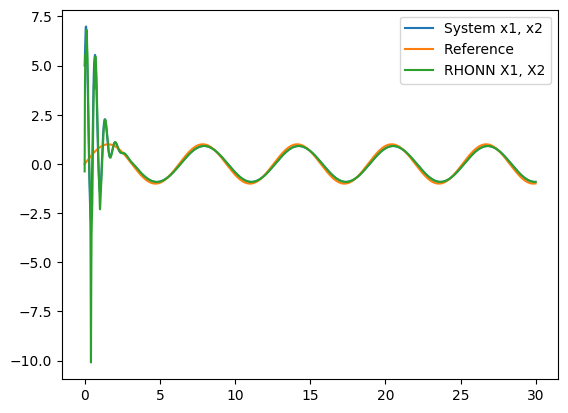

In [733]:
tf = 30 #segundo
T = 0.01
x0 = np.array([5,3])

x = np.zeros( (2,int(tf/T) +1) )
X = np.zeros( (2,int(tf/T) +1) )
u = np.zeros( (int(tf/T) +1) )

x[:,0] = x0
u[0] = 0

np.random.seed(9)
w0 = np.random.normal(0,1,(2,1))
w1 = np.random.normal(0,1,(2,1))

X[:,0] = np.random.normal(0,1,2)

t = np.arange(0,tf,T)
xref = np.sin(t)

tsim = list( range(0, int(tf/T) ) )

S = lambda x: 1 / (1 + np.exp(-x))

P = [10E-10 * np.eye(2), 10E-10 * np.eye(2)] 
Q = [10E-6 * np.eye(2), 10E-6 * np.eye(2)]
R = [10E-15,10E-15]
eta = [0.5,1]

wf = 1

def EKF(H,w,k,edo=0):
    global x,X
    e = x[edo,k] - X[edo,k] # error x0 - X0    
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )  # partial derivative of one of nn state with respect to one nn weight
    M = np.linalg.pinv(R[edo] + H.T@P[edo]@H) # 
    K = P[edo] @ H @ M # Kalman gain
    P[edo] = P[edo] - K@H.T@P[edo] + Q[edo]
    w = w + eta[edo]*K*e
        
    return w
    


for k in tsim:
    #u[k+1] = -10*x[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    u[k+1] = -10*X[0,k] -14*X[1,k] - 14*(X[0,k] - xref[k] ) # control law 
    
    x[0,k+1] = x[0,k] + T *( 3*x[0,k] + 5*x[1,k] )  # system's state
    x[1,k+1] = x[1,k] + T *( 2*x[0,k] + 3*x[1,k] + u[k]) # system's state

    H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    w0=EKF(H,w0,k,0)   
    #X[0,k+1] = w0[0]*S(x[0,k]) + w0[1]*S(x[1,k])
    X[0,k+1] = w0.T@H

    #H = np.array( [ [S(x[0,k])], [S(x[1,k])*S(x[0,k])] ] )
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])**3] ] )
    H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    w1=EKF(H,w1,k,1)
    #X[1,k+1] = w1[0]*S(x[0,k]) + w1[1]*S(x[1,k]) + wf*u[k]
    X[1,k+1] = w1.T@H
    
#tmp= int(.6/T)
tmp = 0

plt.plot(t[tmp:],x[0,tmp:-1], label='System x1, x2')
plt.plot(t[tmp:],xref[tmp:], label='Reference ')
plt.plot(t[tmp:],X[0,tmp:-1], label='RHONN X1, X2')
plt.legend()

In [734]:
import numpy as np



Creating a particle cloud

In [735]:
NUM_PARTICLES = 100
VEL_RANGE = 0.05
valMed = 5

def initialize_particles():
    particles = np.random.rand(NUM_PARTICLES,8)
    particles = particles * np.array( (valMed, valMed,valMed,valMed, VEL_RANGE,VEL_RANGE,VEL_RANGE,VEL_RANGE) )
    particles[:,4:8] -= VEL_RANGE/2.0
    #print(particles[:20,:])
    print("-"*20)
    print("Iniciando!!!")
    print("-"*20)
    return particles

Moving particles according to their velocity state

In [736]:
def apply_velocity(particles):
    particles[:,0] += particles[:,4]
    particles[:,1] += particles[:,5]
    particles[:,2] += particles[:,6]
    particles[:,3] += particles[:,7]
    return particles

Measure each particle's quality

In [737]:
TARGET_COLOUR = np.array( (156,74,38) ) #Señal de referencia en tiempo k

def compute_errors(particles,H1,H2,k):
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        w_1 = int(particles[i,0])
        w_2 = int(particles[i,1])
        w_3 = int(particles[i,2])
        w_4 = int(particles[i,3])
        
        w0 = np.array([ [w_1],[w_2]] )
        w1 = np.array([ [w_3],[w_4]] )
        #X1 = w0[0]*S(x[0,k]) + w0[1]*S(x[1,k])
        #X2 = w1[0]*S(x[0,k]) + w1[1]*S(x[1,k]) + wf*u[k]
        X0 = w0.T@H
        X1 = w1.T@H + wf*u[k]
        
        #pixel_colour = frame[ y, x, :]# Referencia k
        errors[i] = np.sum(  (x[0,k] - X0)**2 + (x[1,k] - X1 )**2 )
    return errors

Assign weights to the particles based on their quality of match

In [738]:
def compute_weights(errors):
    weights = np.max(errors) - errors
    weights [
        (particles[:,0] == 0) |
        (particles[:,1] == 0)     
    ] = 0.0
    
    weights = weights**2
    print(np.sum(weights))
    return weights


Resample particles according to their weights

In [739]:
def resample(particles, weights):
    probabilities = weights / np.sum(weights)
    #print("-"*20)
    #print(probabilities)
    #print("-"*20)
    index_numbers = np.random.choice(
        NUM_PARTICLES,
        size=NUM_PARTICLES,
        p = probabilities)
    particles = particles[index_numbers,:]
    
    w0 = np.mean(particles[:,0])
    w1 = np.mean(particles[:,1])
    w2 = np.mean(particles[:,2])
    w3 = np.mean(particles[:,3])
        
    w_0 = np.array([ [w0],[w1]] )
    w_1 = np.array([ [w2],[w3]] )
    
    return particles, w_0,w_1

Fuzz the particles

In [740]:
0.5*.1

0.05

In [741]:
POS_SIGMA = 1 # cambio de valor 
VEL_SIGMA = .1 # velocidad 

def apply_noise(particles):
    noise = np.concatenate(
    (
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,POS_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
        np.random.normal(0.0,VEL_SIGMA, (NUM_PARTICLES,1)),
    ), axis= 1  )
    particles += noise
    return particles

--------------------
Iniciando!!!
--------------------
44840.42026806449
735015.5354243258
1136097.035763415
760483.5738662942
640215.1825741585
254481.5644156419
61788.29408133856
68161.95923786875
97609.16636292732
246756.548473481
215940.7545546919
314974.9746804442
384913.17101294466
674694.6829324334
584363.9597640196
556934.9254495554
617439.3901003002
896336.4136986063
1157487.045983167
697722.3798763333
397473.5650952549
205069.6050365403
312271.8080260786
226430.09681049988
223094.58381816448
204630.8599578521
55828.30525396716
40893.48142801795
57317.69414415038
94162.22621632136
237288.43672439584
346439.42279089347
379293.73476287513
241710.1912857517
446242.6818965299
652474.7776882204
611702.9894427132
557771.6869934165
238971.94578482583
329701.27711407543
513454.85450468207
526992.2373693731
622407.9954792672
576030.2190198234
827588.332769673
433313.8260347309
265797.3287000021
145759.44956714936
69392.38302468222
85662.86510879075
53081.317558250346
45967.03653212992


86724.59535297076
36587.20651763358
42292.638323066785
30888.677044932367
36133.429272009314
82971.4426459151
36524.31955485581
53400.55506342489
31994.273290925765
23451.565371077377
33739.588674002254
19860.269856002218
44382.85323240137
52562.27214502839
41124.08778839356
47060.52626630168
33602.33930626622
11703.33155415688
10737.787406040234
14627.175128732577
12646.996915213149
29703.273729388024
12586.758530217441
43014.52538698564
7875.75280360526
14632.782973888368
30636.53125818047
29739.426055932294
26935.993443867257
17511.278457156233
20668.95000337171
33262.82342063877
17976.96518143202
14321.830619703906
17487.098660130996
30678.1261828211
37331.291518813225
35945.02183667963
15963.423610897295
33007.769271699966
42404.689576895864
60422.08991133399
40599.59504415725
50587.17555278952
20471.101726754234
44312.76826996018
46468.478555100126
26542.378095395965
17744.219065204463
27522.74854826221
29125.02943677716
27752.31482707881
50492.8652948283
47550.37166888491
11884.

34946.30902433274
35537.449303384026
45192.99566509744
26094.956550075334
38599.777314003775
20570.516656031545
49089.19986471735
48107.525981078266
49017.192458463
27530.62443153196
16885.96175674829
84842.54155739432
34875.60285904517
21684.27415313815
92998.46222956928
83272.02968098427
83257.45855005262
40583.043589380344
17475.051347380046
26011.73987862742
41105.608460028736
83586.34194925384
23527.032490488844
20227.42736435715
17950.357367061835
31569.936360501724
19363.649527361933
17820.007877185417
8381.0543749171
43150.282318050384
41830.588594066205
36853.64550569608
53482.92975777705
27350.673162273077
63847.9245423682
63794.99489331598
26033.587861786636
71215.14260386497
25254.37209276096
101377.23014607235
39422.067985084585
32053.783359010675
19191.811749033117
24181.197160054275
45448.445786481854
33952.74923660336
33431.71786508214
36248.413169703505
56411.81659853873
70465.43956074268
37555.28593686713
17766.36451649812
20181.91516926149
44530.963625623015
138272.5

36762.179035098816
41022.43232298435
40892.54078165652
7649.33514576943
14407.907692064313
131788.9891695944
30119.950187303995
26081.95576899511
55334.34161819792
68029.4655209159
46711.39852323116
42118.01246154137
21525.697374427156
31350.467756747275
37418.82651733363
38200.11895015217
40490.66211506187
31922.151727816596
10894.329583258064
52933.368094030004
37143.779757185875
38058.29344421019
82585.64452407407
43898.48715838401
17067.126032360065
18868.342304962127
36876.687139497604
37412.71225800366
31280.14598288233
44447.2012407016
29643.700446228835
67716.53421254472
25043.73367620144
23709.663202449712
25354.391655124717
29076.99151239077
52806.41454702897
28928.839231660706
36488.816083769765
10465.483391728336
31365.92236695662
27515.71783905439
32837.10567774575
36253.69895444833
34600.10848443621
31805.423096833933
57447.81124272314
18448.63964997157
41904.485713704365
70329.69460583683
29142.891933552375
38306.725769194934
23398.397594033853
24434.7022968577
38848.189

25565.282075703704
33503.80736347327
29679.897183263758
57287.98132539733
27372.063957373342
18202.25275528709
15014.834750725437
19261.914562158374
26899.044971419833
18573.45536589573
14812.6077519313
14775.53524607325
22564.16979691256
18492.451817970323
14690.09424000079
27752.011453798295
13533.201306338824
21613.185971828272
11415.362060334826
14789.972212801735
25113.797504576367
33886.989037772466
6580.295457926573
14857.018603287022
11866.137304936481
11834.859774830127
22617.877574673577
21782.974115307807
14515.927326719922
11145.437122951145
28164.638534998918
26854.03077902172
15661.735452523973
57987.21551335468
18248.12889409172
20842.48915074903
44678.63991433725
76276.06150710428
37256.45474623793
22087.700325435926
35633.54596877595
122002.09679902963
56461.62878212996
74266.62745965867
46267.917692894014
29230.270375143788
28773.62498635862
35782.60021259578
15805.557909969359
23755.942419045634
25944.671471587917
30241.814660603737
25933.612380082108
30866.835414639

26437.288912964454
46114.72002872451
46572.741642266796
33620.119531827266
33551.35536949972
31955.19596240706
32957.360839453795
85919.7573008926
32487.0689996543
56816.967840158184
13088.901152613826
27295.956718687314
15556.489666070323
23124.84038074976
27970.3149927682
20780.49942106678
43419.283901510484
23044.831479817807
28653.2712065921
59554.88723790835
34605.06663046294
211377.9346134758
55818.90341840167
48414.15897480795
63085.92749667035
31078.521602838275
37634.39886015462
23174.26614504233
24733.340307982875
36406.61359307621
21226.31235546931
29967.943350416037
14039.455890179845
41325.11350902574
21133.278925598985
23154.619701838277
25632.09914705682
34346.54945740109
18669.44165676732
46069.4327036196
31420.095600527402
76472.7505358513
40363.61995440034
27325.902419409707
48588.23716366579
33341.56794323794
93412.63911461429
64040.25715699908
19004.31962448198
36513.16945787083
28832.79797724436
14911.153594190293
13654.714094324348
49087.35360213567
48258.73174296

51130.72128487336
37348.74946971575
34544.636483692986
32495.864836829005
11875.795944193831
59138.90681410463
30349.86740964741
31760.829046181683
40736.13757254586
34861.40108527482
53338.6333359782
31054.596560993723
35077.46867320642
59813.81934106648
65356.51453839378
41267.28774205056
48851.62720605378
102645.81471876132
11516.680870672695
30974.128964937026
20243.69139576231
26006.371294512657
53906.40699706623
57266.05644036513
81303.53052819871
66795.53472625486
19038.948605489728
14275.000544712764
15210.913002655658
24117.679844867645
23890.374204013857
21083.448213528613
23889.779383392724
24030.73573511231
12870.67870054763
19101.741855168762
25524.852688098556
34280.553461666466
58241.70370833817
61893.5892110073
26884.759006095534
38834.21526995038
18352.39462264205
8037.362360019257
18718.31727603098
13075.037770349969
23406.318511460995
32003.57976863955
10465.59761527095
16160.888916156242
35593.271228189005
42795.274986486125
28333.997212014037
19775.63693465409
1202

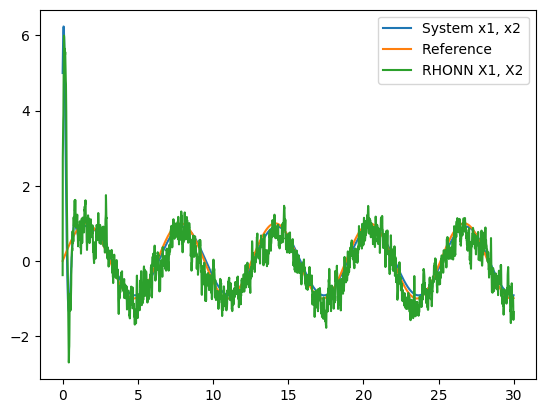

In [742]:
tf = 30 #segundo
T = 0.01
x0 = np.array([5,3])

x = np.zeros( (2,int(tf/T) +1) )
X = np.zeros( (2,int(tf/T) +1) )
u = np.zeros( (int(tf/T) +1) )

x[:,0] = x0
u[0] = 0

np.random.seed(9)
w0 = np.random.normal(0,1,(2,1))
w1 = np.random.normal(0,1,(2,1))

X[:,0] = np.random.normal(0,1,2)

t = np.arange(0,tf,T)
xref = np.sin(t)

tsim = list( range(0, int(tf/T) ) )

S = lambda x: 1 / (1 + np.exp(-x))

P = [10E-10 * np.eye(2), 10E-10 * np.eye(2)] 
Q = [10E-6 * np.eye(2), 10E-6 * np.eye(2)]
R = [10E-15,10E-15]
eta = [0.5,1]

wf = 1

def EKF(H,w,k,edo=0):
    global x,X
    e = x[edo,k] - X[edo,k] # error x0 - X0    
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )  # partial derivative of one of nn state with respect to one nn weight
    M = np.linalg.pinv(R[edo] + H.T@P[edo]@H) # 
    K = P[edo] @ H @ M # Kalman gain
    P[edo] = P[edo] - K@H.T@P[edo] + Q[edo]
    w = w + eta[edo]*K*e
        
    return w


particles = initialize_particles()

for k in tsim:
    
    u[k+1] = -10*x[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*x[1,k] - 14*(x[0,k] - xref[k] ) # control law 
    #u[k+1] = -10*X[0,k] -14*X[1,k] - 14*(X[0,k] - xref[k] ) # control law 
    
    # system's state --------------
    x[0,k+1] = x[0,k] + T *( 3*x[0,k] + 5*x[1,k] )  
    x[1,k+1] = x[1,k] + T *( 2*x[0,k] + 3*x[1,k] + u[k]) # system's state
    # system's state off --------------
    
    
    particles = apply_velocity(particles)
    
    H1 = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    H2 = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    errors = compute_errors(particles,H1,H2,k)
    weights = compute_weights(errors)
    particles,w0,w1 = resample(particles, weights)
    particles = apply_noise(particles)
        
    X[0,k+1] = w0.T@H
    wf = .1
    X[1,k+1] = w1.T@H + 1*u[k]
    
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    #w0=EKF(H,w0,k,0)   
    #w0 = FP_Sys1(H)
    #X[0,k+1] = w0[0]*S(x[0,k]) + w0[1]*S(x[1,k])
    #X[0,k+1] = w0.T@H

    #H = np.array( [ [S(x[0,k])], [S(x[1,k])*S(x[0,k])] ] )
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])**3] ] )
    #H = np.array( [ [S(x[0,k])], [S(x[1,k])] ] )
    #w1=EKF(H,w1,k,1)
    #X[1,k+1] = w1[0]*S(x[0,k]) + w1[1]*S(x[1,k]) + wf*u[k]
    #X[1,k+1] = w1.T@H
    
#tmp= int(.6/T)
tmp = 0

plt.plot(t[tmp:],x[0,tmp:-1], label='System x1, x2')
plt.plot(t[tmp:],xref[tmp:], label='Reference ')
plt.plot(t[tmp:],X[0,tmp:-1], label='RHONN X1, X2')
plt.legend()

"pwd" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
